## Import ##

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import tqdm

from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation
from PIL import Image

from keras.datasets import cifar100

import warnings
warnings.filterwarnings('ignore')

In [ ]:
torch.manual_seed(145)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
device

device(type='cpu')

## Data ##

In [ ]:
df = cifar100.load_data()

169001437/169001437 [==============================] - 11s 0us/step


In [ ]:
df[0][0].shape, df[0][1].shape, 

((50000, 32, 32, 3), (50000, 1))

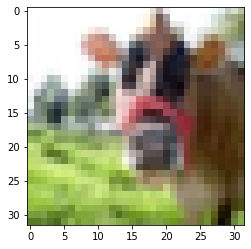

In [ ]:
plt.imshow(df[0][0][0])

In [ ]:
X = [Compose([ToTensor()])(x) for x in df[0][0]]

In [ ]:
X_train_sample, X_valid_sample = random_split(X, [0.8,0.2],)

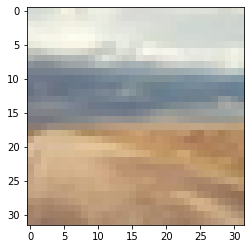

In [ ]:
plt.imshow(X_train_sample[0].permute(1, 2, 0))

We don't use custom dataset here

In [ ]:
X_train, X_valid = DataLoader(X_train_sample, batch_size=256, drop_last=True), DataLoader(X_valid_sample, batch_size=256, drop_last=True)

## Autoencoder ##

In [357]:
class Encoder(nn.Module):
    def __init__(self, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size

        self.left_part = nn.Sequential(nn.Conv2d(3, 3, 3, 2, 0), 
              nn.Conv2d(3, 3, 2, 2, 0), 
              nn.Conv2d(3, 3, 1, 1, 1), 
              nn.MaxPool2d(3, 3), 
              nn.ReLU(), 
              nn.BatchNorm2d(3)
              ) # (self.batch_size, 3, 3, 3)
        
        self.center_part = nn.Sequential(nn.Conv2d(3, 3, 5, 5, 0), nn.MaxPool2d(2,2), nn.ReLU(), nn.BatchNorm2d(3)) # (self.batch_size, 3, 3, 3)

        self.ln = nn.Linear(54, 54)
        self.r = nn.ReLU()
    
    def forward(self, x):
        x_left = self.left_part(x)
        x_center = self.center_part(x)

        x_o = torch.cat([x_left, x_center], dim = 0) # (self.batch_size, 6, 3, 3)
        x_o = x_o.view(self.batch_size, -1)
        x_o = self.ln(x_o)
        x_o = self.r(x_o)
        return x_o # (self.batch_size, 54)

In [358]:
b1 = Encoder(1)

In [359]:
b1(X[0].reshape(1,3,32,32))

tensor([[0.5146, 0.0000, 1.4012, 0.1612, 0.2088, 0.6382, 0.0000, 0.0000, 0.5478,
         0.0000, 0.0000, 0.0000, 0.0000, 0.1481, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.5493, 0.0000, 0.0000, 0.0000, 0.6215, 0.0000,
         0.0000, 0.0000, 0.3268, 0.0000, 0.0447, 0.0042, 0.0000, 0.1415, 0.0000,
         0.1979, 0.0209, 0.0000, 0.4856, 0.1560, 0.0832, 0.4548, 0.4996, 0.0621,
         0.0000, 0.1159, 0.0000, 0.0000, 0.0000, 0.1377, 0.0517, 0.0316, 0.0000]],
       grad_fn=<ReluBackward0>)

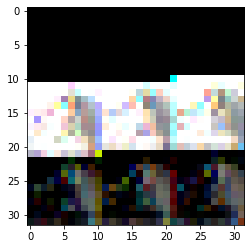

In [ ]:
plt.imshow(nn.Sequential(nn.Conv2d(3, 3, 1, 1, 0), nn.ReLU())(X[0]).detach().numpy().reshape(32,32,3))

In [360]:
class Decoder(nn.Module):
    def __init__(self, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size

        self.seq = nn.Sequential(nn.ConvTranspose2d(6, 3, 3, 1, 0), 
                                 nn.Upsample(scale_factor = 2), 
                                 nn.ReLU(),
                                 nn.BatchNorm2d(3),
                                 nn.ConvTranspose2d(3, 3, 1, 1, 0), 
                                 nn.Upsample(scale_factor = 2),
                                 nn.ReLU(),
                                 nn.BatchNorm2d(3),
                                 nn.ConvTranspose2d(3, 3, 1, 1, 0), 
                                 nn.Upsample(scale_factor = 1.6),
                                 nn.ReLU(),
                                 )
    
    def forward(self, x):
        x = x.view((self.batch_size,6,3,3)) # [1, 6, 3, 3]
        x = self.seq(x)
        return x # [1, 3, 32, 32]

In [361]:
d1 = Decoder(1)

In [362]:
d1(b1(X[0].reshape(1,3,32,32))).shape

torch.Size([1, 3, 32, 32])

## Full model autoencoder ##

In [363]:
class Autoenc(nn.Module):
    def __init__(self, batch_size):
        super(Autoenc, self).__init__()
        self.batch_size = batch_size
        self.encoder = Encoder(self.batch_size)
        self.decoder = Decoder(self.batch_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [364]:
auto = Autoenc(1)

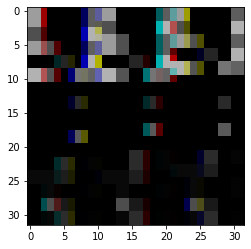

In [365]:
plt.imshow(auto(X[0].reshape(1,3,32,32)).detach().numpy().reshape(32,32,3))

In [366]:
auto.parameters

<bound method Module.parameters of Autoenc(
  (encoder): Encoder(
    (left_part): Sequential(
      (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2))
      (1): Conv2d(3, 3, kernel_size=(2, 2), stride=(2, 2))
      (2): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
      (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (4): ReLU()
      (5): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (center_part): Sequential(
      (0): Conv2d(3, 3, kernel_size=(5, 5), stride=(5, 5))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
      (3): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (ln): Linear(in_features=54, out_features=54, bias=True)
    (r): ReLU()
  )
  (decoder): Decoder(
    (seq): Sequential(
      (0): ConvTranspose2d(6, 3, kernel_size=(3, 3), stride=(1, 1))
      (1): Upsample(scale_fa

## Simple AE ##

In [409]:
class SimpleAE(nn.Module):
    def __init__(self, batch_size):
        super(SimpleAE, self).__init__()
        self.batch_size = batch_size

        # encoder
        self.l1 = nn.Linear(3072, 500)

        # decoder
        self.l2 = nn.Linear(500, 3072)

    def forward(self, x):
        x = x.view((self.batch_size, -1))
        x = self.l1(x)

        x = self.l2(x)
        x = x.view((self.batch_size, 3, 32, 32))
        return x

In [401]:
s_ae = SimpleAE(256)

In [385]:
s_ae(next(iter(X_train))).shape

torch.Size([256, 3, 32, 32])

## Yet another autoencoder ##

In [ ]:
class ae(nn.Module):
    def __init__(self, batch_size):
        super(ae, self).__init__()
        self.batch_size = batch_size

        # encoder
        self.l1 = nn.Linear(3072, 150)
        self.seq1 = nn.Sequential(nn.Conv2d(3,3,3,1,0),
                                  nn.Conv2d(3,3,2,1,0),
                                  nn.MaxPool2d(2,2)) 
        self.l2 = nn.Linear(588, 150)
        self.l3 = nn.Linear(300, 150)


        # decoder
        self.l4 = nn.Linear(150, 256)
        self.l5 = nn.Linear(256, 512)
        self.l6 = nn.Linear(512, 1024)
        self.l7 = nn.Linear(1024, 3072)

    def forward(self, x):
        #encoder
        o1 = x.view((self.batch_size, -1)) # (self.batch_size, 3072)
        o1 = self.l1(o1) # (self.batch_size, 150)
        o2 = self.seq1(x) # (self.batch_size, 3, 14, 14)
        o2 = o2.view(self.batch_size, -1)
        o2 = self.l2(o2) # (self.batch_size, 150)
        o_1_2 = torch.cat([o1, o2], dim = 1) # (self.batch_size, 300)
        x = self.l3(o_1_2)

        # decoder
        x = self.l4(x)
        x = self.l5(x)
        x = self.l6(x)
        x = self.l7(x)
        x = x.view((self.batch_size, 3, 32,32))
        return x

In [ ]:
a1 = ae(256)

In [ ]:
next(iter(X_train)).shape

torch.Size([256, 3, 32, 32])

In [ ]:
a1(next(iter(X_train))).shape

torch.Size([256, 3, 32, 32])

## Train-loop ##

In [ ]:
def train_model(model, train_loader, val_loader, epochs, opt, losses, device):

    model.train()
    train_loss = []
    val_loss = []
    augm = Compose([RandomHorizontalFlip(), RandomRotation(50)])
    for epoch in tqdm.tqdm_notebook(range(epochs)):
        epoch_train_loss = []
        for X_train in tqdm.tqdm_notebook(train_loader):
            X_train = augm(X_train)
            X_train = X_train.to(device)
            opt.zero_grad()
            output = model(X_train)
            step_loss = losses(X_train, output)
            step_loss.backward()
            opt.step()
            epoch_train_loss.append(step_loss.item())
        train_loss.append(np.array(epoch_train_loss).mean())

        model.eval()
        
        with torch.no_grad():
            epoch_val_loss = []
            for X_val in tqdm.tqdm_notebook(val_loader):
                X_val = X_val.to(device)
                output = model(X_val)
                step_loss = losses(X_val, output)
                epoch_val_loss.append(step_loss.item())
            val_loss.append(np.array(epoch_val_loss).mean())

    return train_loss, val_loss

### Simple AE - train ###

In [410]:
s_ae = SimpleAE(256)

In [411]:
optimizer_s_ae = torch.optim.Adam(s_ae.parameters())

In [412]:
loss_s_ae = torch.nn.MSELoss().to(device)

In [413]:
tr_ls_ae, vl_ls_ae = train_model(s_ae, X_train, X_valid, 10, optimizer_s_ae, loss_s_ae, device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

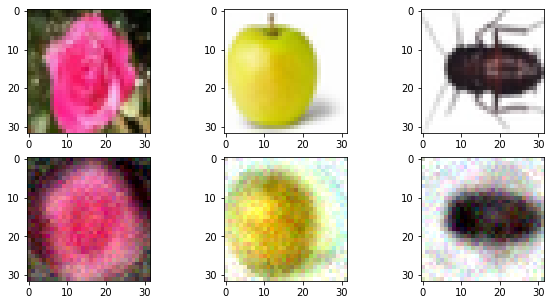

In [419]:
img_i = np.random.randint(0,64)
fig, ax = plt.subplots(2,3, figsize = (10,5))
for i in range(0,3):
    ax[0, i].imshow(next(iter(X_valid))[img_i+i].permute(1, 2, 0).detach().numpy())
    ax[1, i].imshow(s_ae(next(iter(X_valid)))[img_i+i].permute(1, 2, 0).detach().numpy())

### Simple Conv ae ###

In [533]:
class SimpleConv(nn.Module):
    def __init__(self, batch_size):
        super(SimpleConv, self).__init__()
        self.batch_size = batch_size
        self.c1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.c2 = nn.Conv2d(16, 4, 3, padding=1)
        self.mp = nn.MaxPool2d(2, 2,) # [self.batch_size, 4, 16, 16])

        self.tc1 = nn.ConvTranspose2d(4, 16, 2, stride=2, padding = 1)
        self.tc2 = nn.ConvTranspose2d(16, 3, 2, stride=1)
        self.tc3 = nn.ConvTranspose2d(3, 3, 2, stride=1, padding = 0)

    def forward(self, x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.mp(x)

        x = self.tc1(x)
        x = self.tc2(x)
        x = self.tc3(x)

        return x

In [534]:
sc_nn = SimpleConv(256)

In [535]:
sc_nn(next(iter(X_train))).shape

torch.Size([256, 3, 32, 32])

In [536]:
optimizer_sc_nn = torch.optim.Adam(sc_nn.parameters())

In [537]:
loss_sc_nn = torch.nn.MSELoss().to(device)

In [ ]:
tr_lsc_nn, vl_lsc_nn = train_model(sc_nn, X_train, X_valid, 10, optimizer_sc_nn, loss_sc_nn, device)

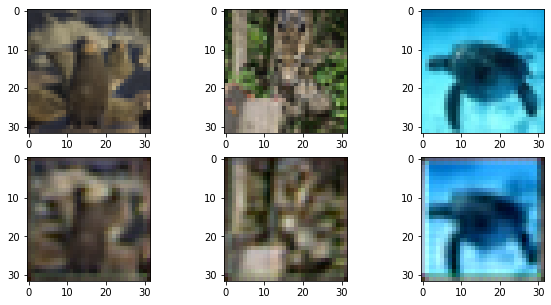

In [539]:
img_i = np.random.randint(0,64)
fig, ax = plt.subplots(2,3, figsize = (10,5))
for i in range(0,3):
    ax[0, i].imshow(next(iter(X_valid))[img_i+i].permute(1, 2, 0).detach().numpy())
    ax[1, i].imshow(sc_nn(next(iter(X_valid)))[img_i+i].permute(1, 2, 0).detach().numpy())

**Best encoder yet. We can use it as encoder and decoder separately**

In [566]:
my_en = nn.Sequential(*list(sc_nn.children())[:3])
my_dec = nn.Sequential(*list(sc_nn.children())[3:])

In [567]:
my_en(next(iter(X_valid)))[0].flatten().shape # use (1, 1024) - dim latent space

torch.Size([1024])

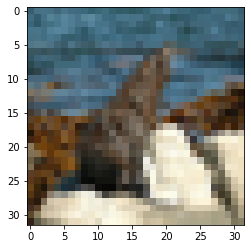

In [578]:
plt.imshow(next(iter(X_valid))[0].permute(1,2,0))

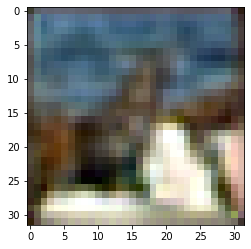

In [573]:
plt.imshow(my_dec(my_en(next(iter(X_valid)))[0]).permute(1,2,0).detach().numpy())

Add some noise and check what will be

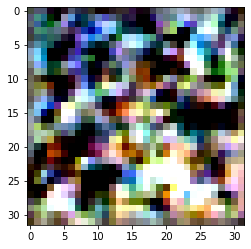

In [587]:
plt.imshow((my_dec(my_en(next(iter(X_valid)))[0] + torch.randn((4, 16, 16)))).permute(1,2,0).detach().numpy())

Nothing interesting

### Yet another autoencoder - train ###

In [ ]:
auto = ae(batch_size=256)

In [ ]:
optimizer = torch.optim.Adam(auto.parameters())

In [ ]:
loss = torch.nn.MSELoss().to(device)

In [ ]:
tr_l, vl_l = train_model(auto, X_train, X_valid, 150, optimizer, loss, device)

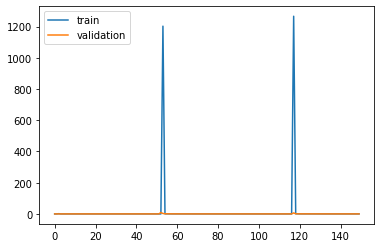

In [338]:
plt.plot(tr_l, label = 'train')
plt.plot(vl_l, label = 'validation')
plt.legend()

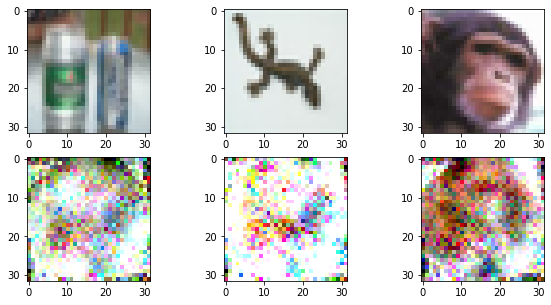

In [347]:
img_i = np.random.randint(0,64)
fig, ax = plt.subplots(2,3, figsize = (10,5))
for i in range(0,3):
    ax[0, i].imshow(next(iter(X_valid))[img_i+i].permute(1, 2, 0).detach().numpy())
    ax[1, i].imshow(auto(next(iter(X_valid)))[img_i+i].permute(1, 2, 0).detach().numpy())

### Full model autoencoder - train ###

In [367]:
fm_model_auto = Autoenc(256)

In [368]:
optimizer_fm_model = torch.optim.Adam(fm_model_auto.parameters())

In [369]:
loss_fm = torch.nn.MSELoss().to(device)

In [370]:
tr_l_fm, vl_l_fm = train_model(fm_model_auto, X_train, X_valid, 5, optimizer_fm_model, loss_fm, device)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

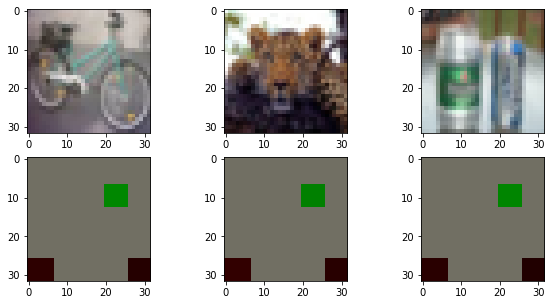

In [378]:
img_i = np.random.randint(0,64)
fig, ax = plt.subplots(2,3, figsize = (10,5))
for i in range(0,3):
    ax[0, i].imshow(next(iter(X_valid))[img_i+i].permute(1, 2, 0).detach().numpy())
    ax[1, i].imshow(fm_model_auto(next(iter(X_valid)))[img_i+i].permute(1, 2, 0).detach().numpy())